# Project 7 - Model combination

**Author: Linh Nguyen**<br>

**StudentID: 23161711**<br>

**Date: Sep 2022**

## 1. Load data and import package

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_project

Mounted at /content/drive
/content/drive/MyDrive/Capstone_project


In [74]:
import numpy as np
import pandas as pd
import re
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report, roc_auc_score
#tf.compat.v1.disable_v2_behavior()



In [3]:
keras.__version__

'2.8.0'

In [4]:
! ls /content/drive/MyDrive/Capstone_project/raw

diagnosis.csv  icd9toicd10cmgem.csv  pyxis.csv	 vitalsign.csv
edstays.csv    medrecon.csv	     triage.csv


# 2. Data cleansing


In [5]:
edstays = pd.read_csv('raw/edstays.csv')
edstays['y_var_adm_text'] = edstays['disposition']
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)

In [6]:
edstays_admit.loc[edstays_admit['race'].str.contains('WHITE'), 'race_color'] = 'WHITE'
edstays_admit.loc[edstays_admit['race'].str.contains('BLACK'), 'race_color'] = 'BLACK'
edstays_admit.loc[edstays_admit['race'].str.contains('ASIAN'), 'race_color'] = 'ASIAN'
edstays_admit.loc[edstays_admit['race'].str.contains('LATINO'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit.loc[edstays_admit['race'].str.contains('HISPANIC'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit.loc[edstays_admit['race_color'].isna(), 'race_color'] = 'OTHER'

In [7]:
edstays_admit['DateTime_in'] = pd.to_datetime(edstays_admit['intime'], format='%d/%m/%Y %H:%M')
edstays_admit['DateTime_out'] = pd.to_datetime(edstays_admit['outtime'], format='%d/%m/%Y %H:%M')

In [8]:
edstays_admit['stay'] = edstays_admit['DateTime_out'] - edstays_admit['DateTime_in']

In [9]:
edstays_admit_1 = edstays_admit.sort_values(by = ['subject_id','DateTime_in'], ascending=True).reset_index(drop=True)

In [10]:
edstay_hist = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_hist[i] = 'NO HISTORY'
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_hist[i] = edstays_admit_1['y_var_adm_text'][i-1]
        else:
            edstay_hist[i] = 'NO HISTORY'

In [11]:
edstay_laststay = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_laststay[i] = np.timedelta64(0, 'D')
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]: 
          edstay_laststay[i] = edstays_admit_1['stay'][i-1]+edstay_laststay[i-1]
        else:
            edstay_laststay[i] = np.timedelta64(0, 'D')

In [12]:
df1 = pd.DataFrame.from_dict(edstay_hist,orient='index')
df1.columns = ['historical_stay_status']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [13]:
df1 = pd.DataFrame.from_dict(edstay_laststay,orient='index')
df1.columns = ['historical_stay_length']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [14]:
edstays_admit_1['historical_stay_length_in_day'] = edstays_admit_1['historical_stay_length']/(np.timedelta64(1, 'D'))

In [15]:
edstays_admit_2 = pd.merge(edstays_admit,edstays_admit_1[['historical_stay_status','historical_stay_length','historical_stay_length_in_day','subject_id','stay_id']],how = 'left',on=['subject_id', 'stay_id'])

In [16]:
edstays_admit_2.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'y_var_adm_text', 'key',
       'race_color', 'DateTime_in', 'DateTime_out', 'stay',
       'historical_stay_status', 'historical_stay_length',
       'historical_stay_length_in_day'],
      dtype='object')

In [17]:
triage = pd.read_csv('raw/triage.csv')


In [18]:
edstay_ad = pd.merge(edstays_admit_2,triage,how = 'left',on=['subject_id', 'stay_id'])

In [19]:
edstay_ad['y_var'] = 0
edstay_ad.loc[edstay_ad['y_var_adm_text'] == 'ADMITTED', 'y_var']  = 1

In [20]:
edstay_ad.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'y_var_adm_text', 'key',
       'race_color', 'DateTime_in', 'DateTime_out', 'stay',
       'historical_stay_status', 'historical_stay_length',
       'historical_stay_length_in_day', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint', 'y_var'],
      dtype='object')

In [21]:
edstay_ad1 = edstay_ad.drop(['subject_id','hadm_id','stay_id','intime','outtime','race', 'gender','race_color','disposition','y_var_adm_text','key', 'DateTime_in', 'DateTime_out','stay','historical_stay_length','chiefcomplaint', 'pain', 'y_var'], axis = 1)

In [22]:
edstay_ad1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   arrival_transport              428284 non-null  object 
 1   historical_stay_status         428284 non-null  object 
 2   historical_stay_length_in_day  428284 non-null  float64
 3   temperature                    405762 non-null  float64
 4   heartrate                      412132 non-null  float64
 5   resprate                       408822 non-null  float64
 6   o2sat                          408594 non-null  float64
 7   sbp                            410935 non-null  float64
 8   dbp                            410124 non-null  float64
 9   acuity                         422216 non-null  float64
dtypes: float64(8), object(2)
memory usage: 35.9+ MB


In [23]:
updated_edstay_ad = edstay_ad1
updated_edstay_ad['temperaturemissing'] = updated_edstay_ad['temperature'].isnull().astype(int)
updated_edstay_ad['heartratemissing'] = updated_edstay_ad['heartrate'].isnull().astype(int)
updated_edstay_ad['respratemissing'] = updated_edstay_ad['resprate'].isnull().astype(int)
updated_edstay_ad['o2satmissing'] = updated_edstay_ad['o2sat'].isnull().astype(int)
updated_edstay_ad['sbpmissing'] = updated_edstay_ad['sbp'].isnull().astype(int)
updated_edstay_ad['dbpmissing'] = updated_edstay_ad['dbp'].isnull().astype(int)
updated_edstay_ad['acuitymissing'] = updated_edstay_ad['acuity'].isnull().astype(int)

In [24]:
num_attr = edstay_ad1.select_dtypes(include=['float64']).columns
cat_attr = edstay_ad1.select_dtypes(include=['O']).columns
#bool_attr = edstay_ad.select_dtypes(include=['bool']).columns

In [25]:
my_imputer = SimpleImputer(strategy = 'median')
updated_edstay_ad[num_attr] = my_imputer.fit_transform(updated_edstay_ad[num_attr])
updated_edstay_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428284 entries, 0 to 428283
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   arrival_transport              428284 non-null  object 
 1   historical_stay_status         428284 non-null  object 
 2   historical_stay_length_in_day  428284 non-null  float64
 3   temperature                    428284 non-null  float64
 4   heartrate                      428284 non-null  float64
 5   resprate                       428284 non-null  float64
 6   o2sat                          428284 non-null  float64
 7   sbp                            428284 non-null  float64
 8   dbp                            428284 non-null  float64
 9   acuity                         428284 non-null  float64
 10  temperaturemissing             428284 non-null  int64  
 11  heartratemissing               428284 non-null  int64  
 12  respratemissing               

In [26]:
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

In [27]:
triage_2 = edstay_ad[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [28]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [29]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint
209834,14913519,33280070,1,NaN
219040,15127661,39766508,1,NaN
230046,15376111,34216718,1,NaN
241580,15632852,37860864,0,NaN
307992,17192157,31192693,0,NaN
322362,17526143,30744048,1,NaN
356784,18321345,37024607,1,NaN
360935,18425846,33948058,1,NaN


In [30]:
triage_2.loc[triage_2['chiefcomplaint'].isna(),'chiefcomplaint'] = ''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
triage_2[triage_2['chiefcomplaint'].isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [33]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2.chiefcomplaint = triage_2.chiefcomplaint.apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [34]:
df_pre_icd_full = pd.read_csv('previous_icd_code.csv')

triage_3 = pd.merge(triage_2,df_pre_icd_full, how = "left",on=['subject_id', 'stay_id'])

# 2. Text data overview

In [ ]:
# 2. Split the dataset

In [35]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(triage_3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(triage_3) * 0.20)]
#create val index  = 0.20 to 0.30 * random index
val_index = ind[int(len(triage_3) * 0.20):int(len(triage_3) * 0.30)]
#create train index = 0.30 * random index to end
train_index = ind[int(len(triage_3) * 0.30):]

In [36]:
train_samples_chief =  triage_3.chiefcomplaint[train_index]
train_samples_his =  triage_3.pre_icd_code[train_index]
val_samples_chief =  triage_3.chiefcomplaint[val_index]
val_samples_his =  triage_3.pre_icd_code[val_index]
test_samples_chief =  triage_3.chiefcomplaint[test_index]
test_samples_his =  triage_3.pre_icd_code[test_index]
train_samples_o =  updated_edstay_ad.iloc[train_index]
val_samples_o =  updated_edstay_ad.iloc[val_index]
test_samples_o =  updated_edstay_ad.iloc[test_index]
train_labels =  triage_3.y_var[train_index]
val_labels = triage_3.y_var[val_index]
test_labels = triage_3.y_var[test_index]

# 3. Embedding for chief complaint and historical icd code

### 3.1 Embedding for chief complaint

In [37]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [38]:
#print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'abd', 'l']

In [39]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 3,  2, 28, 20,  0])

In [40]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [41]:
#load the model w2vec for chief complaint:
model_w2v = KeyedVectors.load_word2vec_format('W2vec/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [42]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4220 words (156 misses)


In [43]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 3.2 Embedding for historical icd code group

In [44]:
his_icd_top198 = pd.read_csv('top198historical_icd.csv')

In [45]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [46]:
#top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [47]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [48]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

### 3.3 Concat 2 embedding

In [ ]:
#tf.concat([embedding_layer(x_train[0]),[embedding_layer_his(x_train[0])]],0)

# 4 BiLSTM model using historical and current data (historical icd code & chief complaint)

In [51]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()
x_train_o = trans_pip.fit_transform(train_samples_o)
y_train = np.array(train_labels)

x_val = vectorizer(np.array([[s] for s in val_samples_chief])).numpy()
x_val_his = vectorizer_his(np.array([[s] for s in val_samples_his])).numpy()
x_val_o = trans_pip.transform(val_samples_o)
y_val = np.array(val_labels)



In [53]:
x_train_o.shape

(299799, 23)

In [65]:

#Optimized parameters for LSTM: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (23,))

def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(100, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(50, kernel_initializer = 'he_normal', activation="relu")(x)
  x = keras.layers.Dense(1,  activation="sigmoid")(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_LSTM():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.LSTM(114, return_sequences=True, activation = 'tanh'))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.LSTM(114, activation = 'tanh'))(x)
  x = keras.layers.Dense(114/2,activation = 'tanh')(x)
  preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = preds)
  return model
  
  
mlp = create_mlp(23)
lstm = create_LSTM()


In [66]:
combinedInput = keras.layers.concatenate([mlp.output, lstm.output])
#x = keras.layers.Dense(1, activation="relu")(combinedInput)
#x = keras.layers.Dense(1, activation="relu")(x)
x = keras.layers.Dense(1, activation="sigmoid")(combinedInput)
model = keras.models.Model(inputs=[mlp.input, lstm.input], outputs=x)


In [67]:
#weights = [1-(sum(train_labels)/len(train_labels)),sum(train_labels)/len(train_labels)]
#model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', loss_weights = weights, metrics = "accuracy")

model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = "accuracy")
early = EarlyStopping(monitor='val_loss', patience=10)

In [68]:
weights = {0:1-(sum(y_train)/len(y_train)),1:sum(y_train)/len(y_train)}
model.fit(x=[x_train_o,[x_train_his,x_train]], y = y_train, validation_data=([x_val_o,[x_val_his,x_val]], y_val), batch_size = 256, epochs=100, callbacks=[early],class_weight = weights)


Epoch 1/100
1172/1172 [==============================] - 23s 13ms/step - loss: 0.3243 - accuracy: 0.5945 - val_loss: 0.6857 - val_accuracy: 0.5950
Epoch 2/100
1172/1172 [==============================] - 14s 12ms/step - loss: 0.3204 - accuracy: 0.5945 - val_loss: 0.6840 - val_accuracy: 0.5950
Epoch 3/100
1172/1172 [==============================] - 14s 12ms/step - loss: 0.3170 - accuracy: 0.5945 - val_loss: 0.6756 - val_accuracy: 0.5950
Epoch 4/100
1172/1172 [==============================] - 14s 12ms/step - loss: 0.3112 - accuracy: 0.5945 - val_loss: 0.6610 - val_accuracy: 0.5950
Epoch 5/100
1172/1172 [==============================] - 14s 12ms/step - loss: 0.3031 - accuracy: 0.5945 - val_loss: 0.6421 - val_accuracy: 0.5950
Epoch 6/100
1172/1172 [==============================] - 14s 12ms/step - loss: 0.2943 - accuracy: 0.5945 - val_loss: 0.6236 - val_accuracy: 0.5950
Epoch 7/100
1172/1172 [==============================] - 14s 12ms/step - loss: 0.2867 - accuracy: 0.5945 - val_loss: 0

In [79]:
model.save('/content/drive/MyDrive/Capstone_project/model.h5')

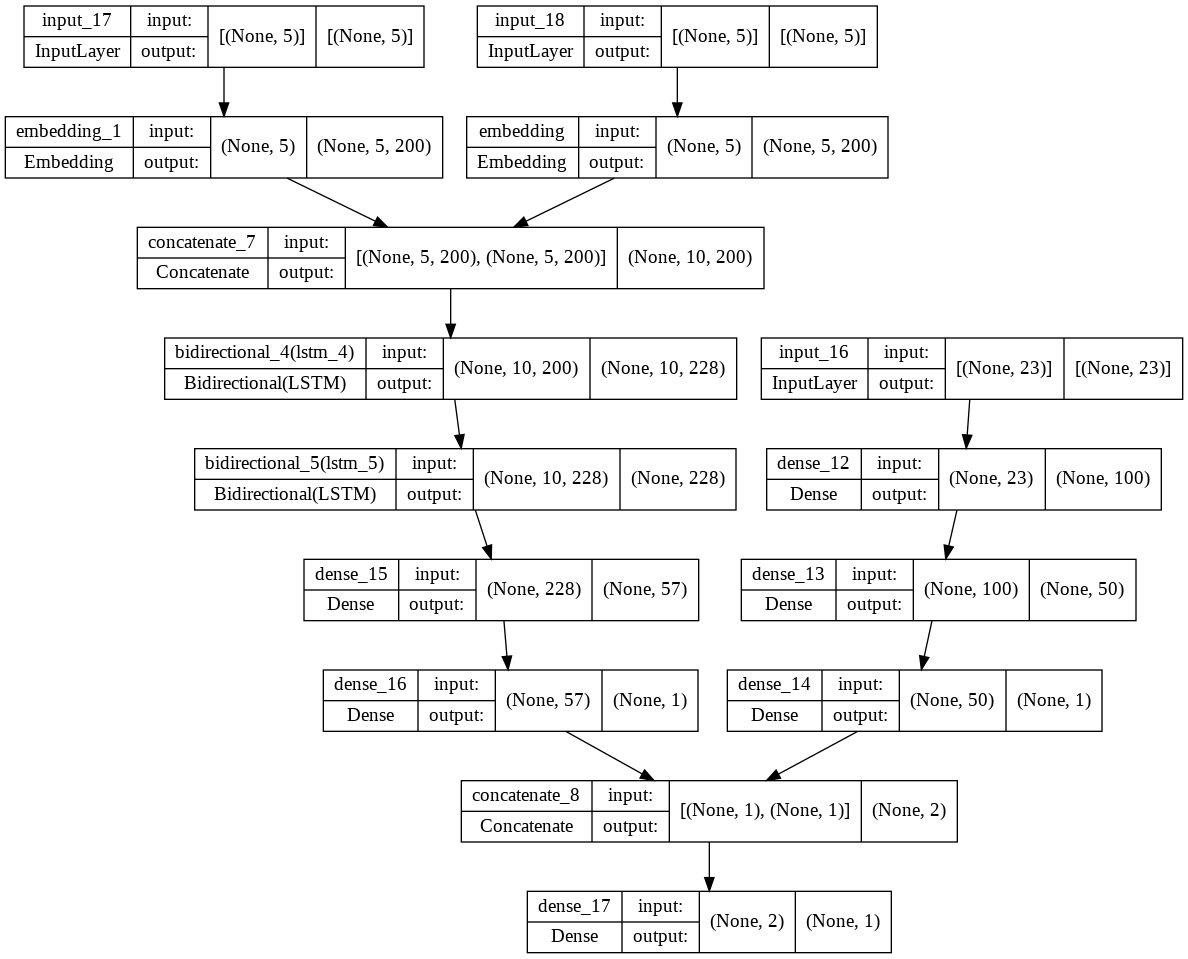

In [77]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [71]:
x_test = vectorizer(np.array([[s] for s in test_samples_chief])).numpy()
x_test_his = vectorizer_his(np.array([[s] for s in test_samples_his])).numpy()
x_test_o = trans_pip.transform(test_samples_o)
y_test = np.array(test_labels)

In [75]:
y_test_pred = model.predict(x=[x_test_o,x_test_his, x_test])

print("roc auc for validation set:", roc_auc_score(y_test, y_test_pred))
y_pred_test_class = np.where(y_test_pred>0.5, 1, 0)
print("accuracy score for test set:", accuracy_score(y_test, y_pred_test_class))
print("f1 score for test set:", f1_score(y_test, y_pred_test_class))

roc auc for validation set: 0.8475190789726195
accuracy score for test set: 0.7608106845988606
f1 score for test set: 0.651600176852702


In [78]:
pd.DataFrame(x_test_o).to_csv("x_test_o.csv",index=False)
pd.DataFrame(x_test).to_csv("x_test.csv",index=False)
pd.DataFrame(x_test_his).to_csv("x_test_his.csv",index=False)
pd.DataFrame(train_samples_o).to_csv("train_samples_o.csv",index=False)
pd.DataFrame(test_samples_his).to_csv("test_samples_his.csv",index=False)
pd.DataFrame(test_samples_chief).to_csv("test_samples_chief.csv",index=False)
pd.DataFrame(edstay_ad1).to_csv("edstay_ad1.csv",index=False)